# Search with DocAI and LLMs

**What?**

Ask questions of the PGA rulebook [PGA Rules](https://www.usga.org/content/usga/home-page/rules-hub/2023-rules-of-golf/2023-rules-resources.html).

**Sources:**

The pdf for [2023 PGA Rules](https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf).

**Tools:**

- Vertex AI LLM Embedding API
  - `google.cloud.aiplatform.private_preview import language_models.TextEmbeddingModel.from_pretrained('embedding-gecko-001')`
- Vertex AI GenAI Language Model API
  - `google.cloud.aiplatform.private_preview import language_models.TextGenerationModel.from_pretrained('text-bison-001')`
- Input file processing into documents/elements with GCP Document AI
  - `google.cloud.documentai.DocumentProcessorServiceClient()`
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook

**How:**

- Create documents from the source information.
  - <u>Definition</u>: a document is a section of the rules
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

**What is Unique?**

An LLM is likely unexposed to a users private content.  This appoach constructs a summarization prompt for an LLM by first retriving context for the question from the users documents using embeddings.  This also allows the response to be accompanied by direct reference to the users documentation used in the prompt.

**Notes**

- An LLM is likely trained on web based resources that probably include lots of general knowledge, even information like what is used here.  It is also likely knowledgable of past outdated information which can be a benefit - or detriment - to accuracy.  This approach directly uses the version of the document that currently applies.

**References**

- [Vertex AI GenAI Studio Manual](https://docs.google.com/document/d/1ruSHqTspc7alqfWEpdJrQHSDSn962NNcuzC8kCQN5Q8/edit#heading=h.6aa03uz2ngbb)
- [Document AI](https://cloud.google.com/document-ai/docs/overview)
- Document AI [Parsers](https://cloud.google.com/document-ai/docs/processors-list)
- Document AI [Python Client](https://cloud.google.com/python/docs/reference/documentai/latest)

**Internal References**

This approach was adapted from the excellent [Intra-Knowledge Q&A](https://colab.sandbox.google.com/drive/1_rlAvsa1xAQaQZ281vkpq0CyIzVFQLXa#scrollTo=aImqcxUQqj2n) example created by OCTO

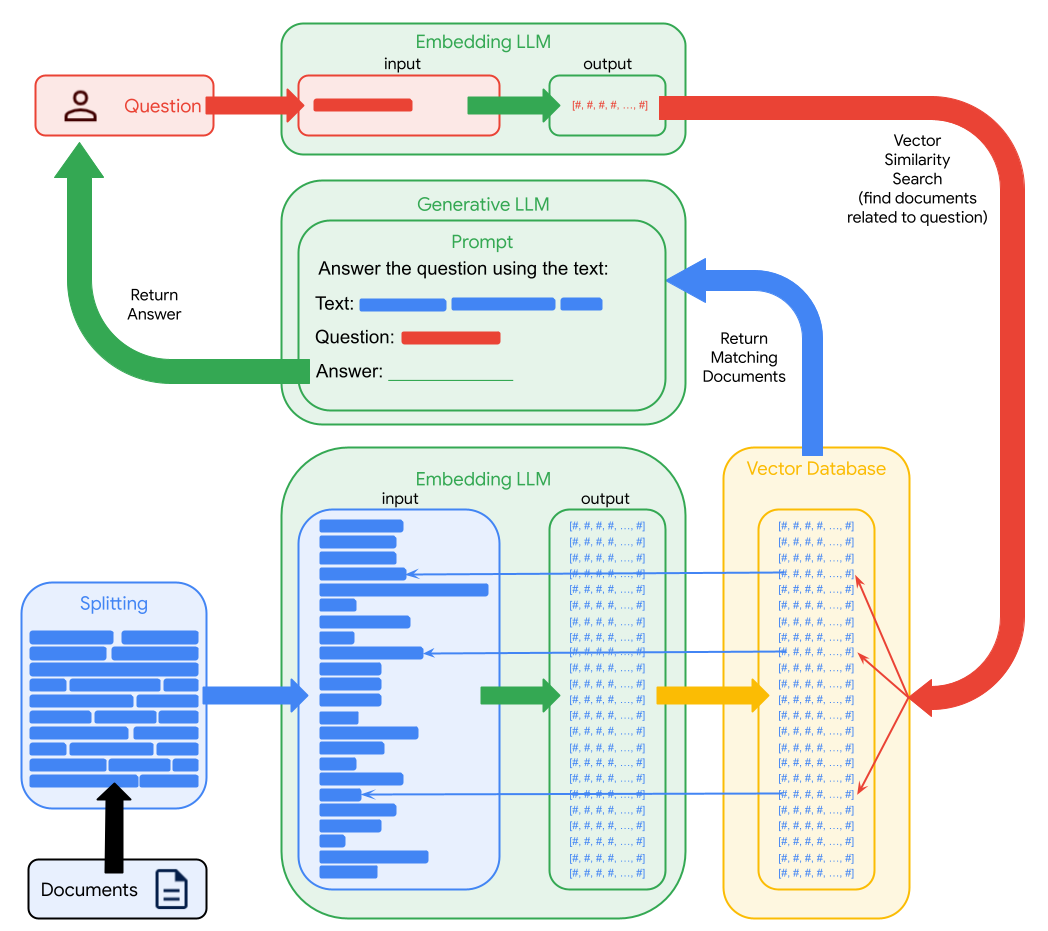

---
## Colab Setup

In [1]:
PROJECT_ID = 'mg-ce-demos' # replace with project ID

---
## Installs

In [6]:
# Vertex AI GenAI Studio SDK - Update the aiplatform SDK
!pip install vertexai
!pip install google.cloud.aiplatform -U -q

# for working with embeddings locally
!pip install scann

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q
!pip install PyPDF2 -U -q
!pip install Pillow -U -q

ERROR: Could not find a version that satisfies the requirement scann (from versions: none)
ERROR: No matching distribution found for scann


In [3]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI FOr This Project
!gcloud services enable aiplatform.googleapis.com



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update



To take a quick anonymous survey, run:
  $ gcloud survey



**RESTART RUNTIME**

---
## Setup

Inputs

In [4]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'mg-ce-demos'

In [5]:
LOCATION = 'us'

Packages

In [5]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np

from google.cloud.aiplatform.private_preview import language_models
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage

Clients

In [6]:
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

In [7]:
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(PROJECT_ID)

In [8]:
bucket.name

'mg_demos'

Local Storage

In [9]:
INDEX_PATH = '/pga_rules_index'

In [10]:
if os.path.exists(INDEX_PATH):
    print(f'Already Exists: {INDEX_PATH}')
else:
    os.makedirs(INDEX_PATH)
    print(f'Created: {INDEX_PATH}')

Created: /pga_rules_index


Inputs:

In [11]:
# url for the source document
source_document = 'https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf'

In [12]:
# first question to ask
question = "What are the rules of golf?"

---
## Vertex LLM Setup

[User Guide](https://docs.google.com/document/d/1ruSHqTspc7alqfWEpdJrQHSDSn962NNcuzC8kCQN5Q8/edit#heading=h.jvgs2e6uly1p)

In [13]:
# create links to model: embedding api and text generation
embedding_model = language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko-001')
textgen_model = language_models.TextGenerationModel.from_pretrained('text-bison-001')

Test embedding model:

In [14]:
embeddings = embedding_model.get_embeddings([question])
for e in embeddings:
  v = e.values
  print(len(v), v)

768 [0.0316314697265625, -0.01166587695479393, -0.006300797685980797, 0.017489105463027954, -0.005900177173316479, -0.02151036262512207, 0.008604343980550766, 0.037899214774370193, -0.0026729407254606485, -0.014560158364474773, -0.04838506132364273, -0.059318363666534424, 0.02546839229762554, -0.013443388044834137, -0.039047010242938995, -0.04590214416384697, -0.05360802635550499, -0.0421881303191185, 0.039565976709127426, 0.01059271115809679, -0.057681333273649216, -0.025944463908672333, -0.029632797464728355, 0.006887701340019703, 0.019036123529076576, -0.06428229063749313, 0.007325250189751387, -0.03329579532146454, -0.017435278743505478, -0.005081846844404936, 0.0059798830188810825, -0.028137339279055595, -0.02472597546875477, 0.007539183832705021, -0.024996059015393257, 0.04997926577925682, -0.0020395340397953987, -0.0009561472688801587, 0.011261219158768654, 0.08309277892112732, 0.05312793701887131, -0.01399968657642603, 0.0044805146753787994, -0.01950620487332344, -0.00589981116

Test test generation (llm) model:

In [15]:
textgen_model.predict(question)

The rules of golf are a set of regulations governing the sport of golf. They are designed to ensure fair play and consistency between different courses and tournaments. The rules are overseen by the Royal and Ancient Golf Club of St Andrews, which is the governing body of golf worldwide.

The rules of golf are divided into three sections:

* Rules of play: These rules cover the basic principles of the game, such as how to hit the ball, how to score, and how to handle penalties.
* Rules of equipment: These rules cover the types of equipment that can be used in golf, such as clubs, balls, and

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [16]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/801452371447/locations/us/processors/319a3f9047ce5c13"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/801452371447/locations/us/processors/319a3f9047ce5c13:process"
create_time {
  seconds: 1683650436
  nanos: 78208000
}
default_processor_version: "projects/801452371447/locations/us/processors/319a3f9047ce5c13/processorVersions/pretrained-form-parser-v1.0-2020-09-23"

---
## Get The Document

Copy the PDF to memory:

In [17]:
response = requests.get(source_document)

In [18]:
type(response.content)

bytes

Split the PDF into a document per page:

In [19]:
pdf = PyPDF2.PdfReader(io.BytesIO(response.content))

In [20]:
len(pdf.pages)

260

In [21]:
pdfs = []
for page_num, page in enumerate(pdf.pages, 1):
  writer = PyPDF2.PdfWriter()
  writer.add_page(page)
  with io.BytesIO() as bytes_stream:
    pdfs.append(writer.write(bytes_stream)[1].getbuffer().tobytes())

---
## Files From Previous Run on GCS
If available

In [22]:
PRIOR_PARSE = False
if len(list(bucket.list_blobs(prefix = f'genai{INDEX_PATH}'))) > 0:
  print('Copying previous run to local...')
  !gsutil -m cp -r gs://{bucket.name}/genai{INDEX_PATH}/results.* ../{INDEX_PATH}
  !gsutil -m cp -r gs://{bucket.name}/genai{INDEX_PATH}/documents.* ../{INDEX_PATH}
  PRIOR_PARSE = True
else:
  print('No previous run available to copy over')

No previous run available to copy over


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [23]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [24]:
def docai_runner(p, start, raw_document):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document, name = parser.name)))

In [25]:
if PRIOR_PARSE:
  print('Loading Prior Results')
  with open(INDEX_PATH + '/results.json', 'r') as f:
    results = [json.loads(row) for row in f.read().splitlines()]
else:
  print('No Prior Results, Parsing with Document AI')
  print(f"The Expected runtime for the parsing is {(len(pdfs)/adjust_rate_limit):.2f} minutes")
  results = [None] * len(pdfs)
  start = time.time()
  with concurrent.futures.ThreadPoolExecutor(max_workers = len(pdfs)) as executor:
    futures = [
        executor.submit(
            docai_runner,
            p, start,
            documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
        ) for p, pdf in enumerate(pdfs)
    ]
    for future in concurrent.futures.as_completed(futures):
      #result = futures[future]
      results[future.result()[0]] = (Document.to_dict(future.result()[1].document))

No Prior Results, Parsing with Document AI
The Expected runtime for the parsing is 4.33 minutes


In [26]:
len(pdfs), len(results)

(260, 260)

In [27]:
if PRIOR_PARSE:
  print('Loading Prior Documents')
  with open(INDEX_PATH + '/documents.json', 'r') as f:
    documents = [json.loads(row) for row in f.read().splitlines()]

  page_images = []
  for r, result in enumerate(results):
    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)
else:
  documents = []
  page_images = []
  for r, result in enumerate(results):
    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)

    tables = []
    for t, table in enumerate(result['pages'][0]['tables']):
      table_txt = ''
      if 'text_anchor' in table['layout'].keys():
        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
          if t == 0 and s == 0: start = 0
          else: start = int(segment['start_index'])
          end = int(segment['end_index'])
          table_txt += result['text'][start:end+t]

      vertices = []
      for vertex in table['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))
      tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

      documents.append(
          dict(
              page_content = table_txt,
              metadata = dict(
                  page = r+1,
                  table = t+1,
                  row = len(documents),
                  filename = source_document.split('/')[-1]
              ),
              extras = dict(
                  #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                  vertices = vertices
              )
          )
      )

    for p, paragraph in enumerate(result['pages'][0]['paragraphs']):

      paragraph_txt = ''
      for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
        if p == 0 and s == 0: start = 0
        else: start = int(segment['start_index'])
        end = int(segment['end_index'])
        paragraph_txt += result['text'][start:end+1]

      vertices = []
      for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))

      use_paragraph = True
      for t_shape in tables:
        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
        if p_shape.intersects(t_shape): use_paragraph = False

      if use_paragraph:
        documents.append(
            dict(
                page_content = paragraph_txt,
                metadata = dict(
                    page = r+1,
                    paragraph = p+1,
                    row = len(documents),
                    filename = source_document.split('/')[-1]
                ),
                extras = dict(
                    #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                    vertices = vertices
                )
            )
        )

len(documents)

1805

In [28]:
print(documents[300]['page_content'])

3.3c Failure to Hole Out
A


In [29]:
print(documents[300]['metadata'])

{'page': 39, 'paragraph': 2, 'row': 300, 'filename': '2023%20Rules%20of%20Golf.pdf'}


---
## Get Embeddings


In [30]:
rate_limit_minute = 150

In [31]:
if PRIOR_PARSE:
  print('Embeddings created on previous run.')
else:
  print(f"The expected run time for embeddings is {(len(documents)/rate_limit_minute):.2f} minutes")
  start = time.time()
  for d, document in enumerate(documents):
    if d % rate_limit_minute == 0:
      time.sleep(((time.time() - start) % 60) + 10)
      start = time.time()
    text = document['page_content']
    if text:
      embed = embedding_model.get_embeddings([text])[0].values
    else:
      embed = []
    documents[d]['embedding'] = embed

The expected run time for embeddings is 12.03 minutes


## Create Embeddings Database


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

In [81]:
index = np.empty((len(documents), len(documents[0]['embedding'])))
index = np.nan_to_num(index)

index.shape

(1805, 768)

In [82]:
for i in range(index.shape[0]):
  if documents[i]['embedding']:
    index[i] = documents[i]['embedding']
normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

In [83]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
builder = scann.scann_ops_pybind.builder(
    normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

searcher = builder.tree(
    num_leaves=index.shape[0], #num_leaves
    num_leaves_to_search=index.shape[0], #num_leaves_to_search
    training_sample_size=index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          index.shape[0]
          ).build()

In [84]:
def search_index(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [85]:
search_index(question, 4)

[(17, 0.8190234), (3, 0.8098572), (34, 0.8098572), (8, 0.78261375)]

---
## Save To GCS For Future Runs

It can take awhile to run the parsing job above so save results for future runs of this notebook.

In [86]:
if PRIOR_PARSE:
  print('Already on GCS, this session used a copy.')
else:
  with open(INDEX_PATH + '/results.json', 'w') as f:
    for result in results:
      f.write(json.dumps(result))
      f.write('\n')
  !gsutil -m cp {INDEX_PATH}/results.json gs://{bucket.name}/genai{INDEX_PATH}/results.json
  with open(INDEX_PATH + '/documents.json', 'w') as f:
    for doc in documents:
      f.write(json.dumps(doc))
      f.write('\n')
  !gsutil -m cp {INDEX_PATH}/documents.json gs://{bucket.name}/genai{INDEX_PATH}/documents.json

Copying file:///pga_rules_index/results.json [Content-Type=application/json]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1/1 files][209.5 MiB/209.5 MiB] 100% Done                                    
Operation completed over 1 objects/209.5 MiB.                                    
Copying file:///pga_rules_index/documents.json [Content-Type=applicatio

---
## Q&A With PGARuleBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Checks to see if the section closest to the response/answer was included in the sections of the rules provided in the prompt.
- Prepares and presents all the information back to the user

In [87]:
def pga_rule_bot(question, print_results = True):

    # Get the score for the closest match
    score = search_index(question, k = 1)[0][1]
    # retrieve related documents - the nubmer is based on the distance score from the closest match
    relevant_documentation = search_index(question, k = 1 + 2*int(10*(1-score)))

    #context = "\n".join([f'Context {c}:\n' + doc.page_content for c, (doc, score) in enumerate(relevant_documentation)])
    context = "\n".join([f'Context {c+1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])
    prompt = f"""
      Give a detailed answer to the question using information from the provided contexts.

      {context}

      Question:
      {question}

      Answer and Explanation:
    """

    #print(prompt)

    response = textgen_model.predict(prompt)

    likely_source = search_index(response, k=1)
    likely_document = documents[likely_source[0][0]]

    # is likely_source in relevant_documentation?
    if likely_document['page_content'] in [documents[doc[0]]['page_content'] for doc in relevant_documentation]:
      #print('likely is in relevant')
      likely = True
    else:
      #print('likely is not in relevant')
      #likely = False
      # get most relevant context instead:
      likely = True
      likely_source = relevant_documentation[0:1]
      likely_document = documents[relevant_documentation[0][0]]

    if print_results:
      display(IPython.display.Markdown("## Response"))
      display(IPython.display.Markdown("### Question"))
      display(IPython.display.Markdown(f'{question}'))
      display(IPython.display.Markdown("### Answer"))
      display(IPython.display.Markdown(f'{response}'))
      if likely:
        display(IPython.display.Markdown("### Why?"))
        display(IPython.display.Markdown(f"{likely_document['page_content']}"))
        display(IPython.display.Markdown(f"* page: {likely_document['metadata']['page']}, relevance to answer: {likely_source[0][1]:.2f}"))
        display(IPython.display.Markdown(f"* {source_document}#page={likely_document['metadata']['page']}"))
      display(IPython.display.Markdown("### Sources"))
      #display(IPython.display.Markdown("\n".join(f"* {source_document}#page={doc[0].metadata['page']}\n\t* Document: {doc[0].metadata['filename']}, page: {doc[0].metadata['page']}, relevance to question: {doc[1]:.2f}\n\t* {doc[0].page_content}" for doc in relevant_documentation)))
      display(IPython.display.Markdown("\n".join(f"* {source_document}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}" for doc in relevant_documentation)))

    if likely:
      font = PIL.ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 20)
      #document_image = PIL.Image.open(io.BytesIO(documents[likely_source[0][0].metadata['row']]['extras']['image']))
      document_image = page_images[likely_document['metadata']['page']-1]
      draw = PIL.ImageDraw.Draw(document_image)
      vertices = documents[likely_document['metadata']['row']]['extras']['vertices']
      draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']
      ], outline = 'green')
      IPython.display.display(document_image.resize((800, 1000)))

    return

## Response

### Question

What is an unplayable lie?

### Answer

An unplayable lie is a ball that cannot be played as it lies. This can be because the ball is embedded in the ground, in a water hazard, or in a position where it is impossible to make a stroke. If a player's ball is unplayable, they may take relief under Rule 19.

### Why?

Loose impediments and movable obstructions are not part of the lie of a ball.
L

* page: 224, relevance to answer: 0.70

* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=224

### Sources

* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=224
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 224, relevance to question: 0.70
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=168
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 168, relevance to question: 0.70
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=252
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 252, relevance to question: 0.69
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=118
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 118, relevance to question: 0.69
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=98
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 98, relevance to question: 0.68

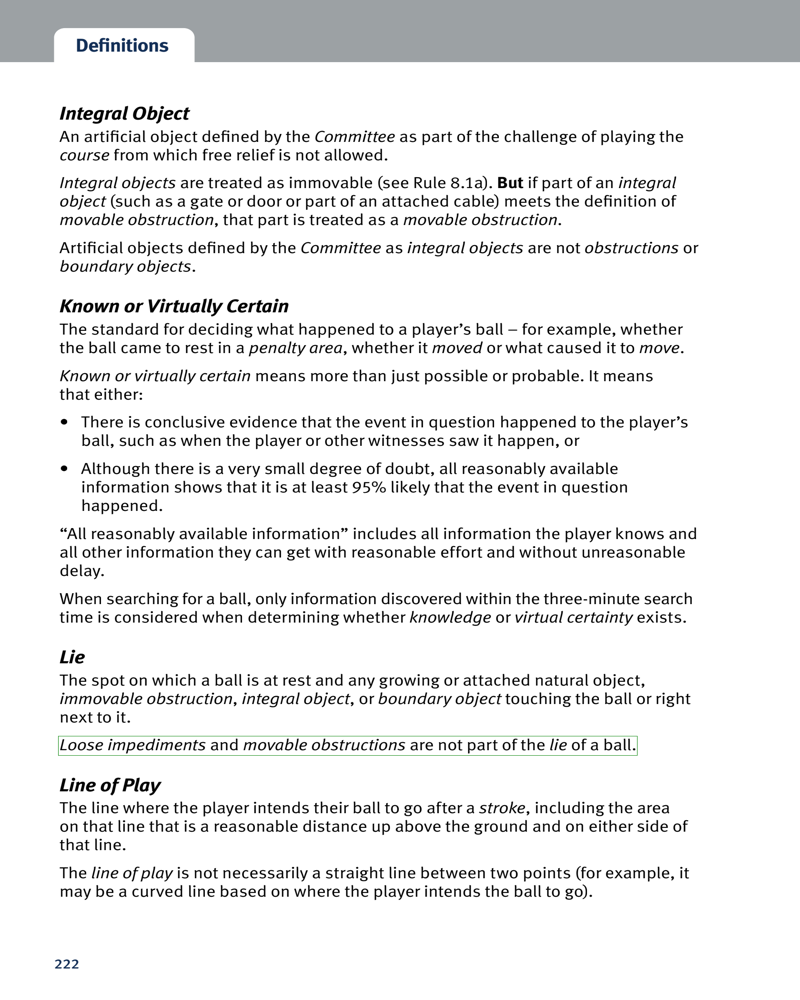

In [89]:
pga_rule_bot("What is an unplayable lie?")

## Response

### Question

Does a player lose a stroke when repairing an aerated green?

### Answer

A player does not lose a stroke when repairing an aerated green.

Aeration holes are considered ground under repair and are therefore allowed to be repaired without penalty. However, if the player's ball is moved during the repair process, they will incur a one-stroke penalty under Rule 9.4b.

### Why?

(1) Removal of Sand and Loose Soil. Sand and loose soil on the putting green may
be removed without penalty.
(2) Repair of Damage. A player may repair damage on the putting green without
penalty by taking reasonable actions to restore the putting green as nearly as
possible to its original condition, but only:
• By using their hand, foot or other part of the body or a normal ball-mark repair
tool, tee, club or similar item of normal equipment, and
• Without unreasonably delaying play (see Rule 5.6a).
But if the player improves the putting green by taking actions that exceed what
is reasonable to restore the putting green to its original condition (such as by
creating a pathway to the hole or by using an object that is not allowed), the
player gets the general penalty for breach of Rule 8.1a.
"Damage on the putting green" means any damage caused by any person
(including the player) or outside influence, such as:
• Ball marks, shoe damage (such as spike marks) and scrapes or indentations
caused by equipment or a flagstick,
• Old hole plugs, turf plugs, seams of cut turf and scrapes or indentations from
maintenance tools or vehicles,
• Animal tracks or hoof indentations, and
• Embedded objects (such as a stone, acorn, hail or tee) and indentations
caused by them.
But "damage on the putting green” does not include any damage or conditions
that result from:
•

* page: 106, relevance to answer: 0.88

* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=106

### Sources

* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=106
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 106, relevance to question: 0.77
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=221
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 221, relevance to question: 0.76
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=78
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 78, relevance to question: 0.75
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=133
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 133, relevance to question: 0.75
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=77
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 77, relevance to question: 0.75

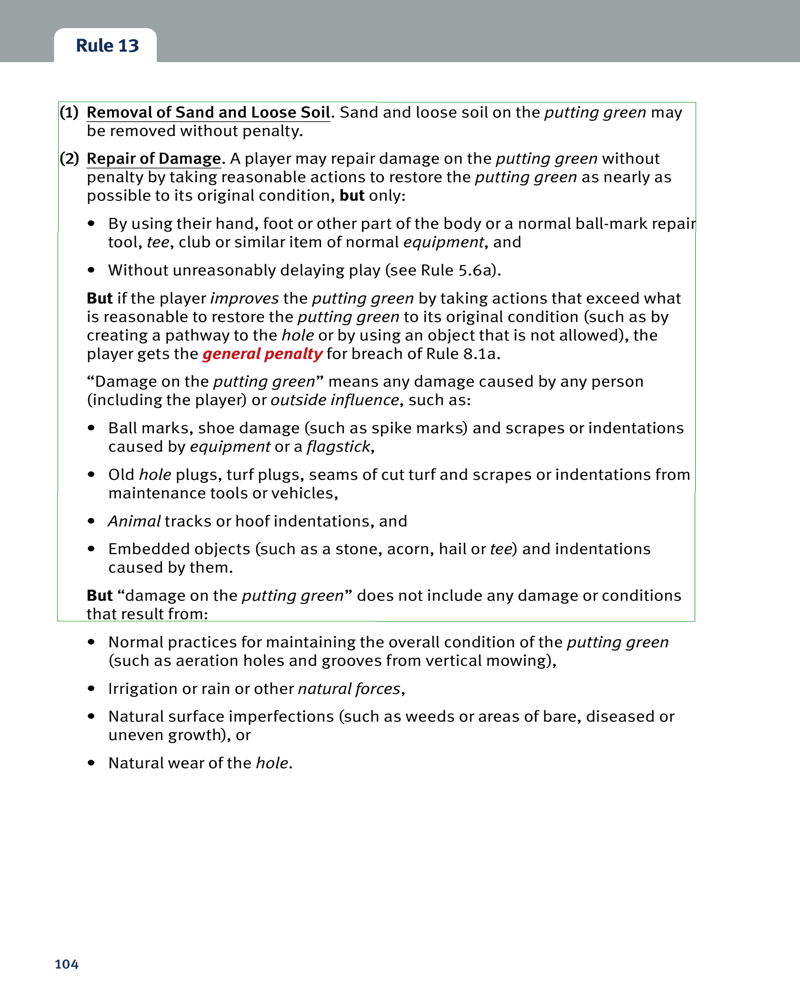

In [90]:
pga_rule_bot("Does a player lose a stroke when repairing an aerated green?")

## Response

### Question

Is there a maximum amount of time that a golf round can take?

### Answer

There is no maximum amount of time that a golf round can take.

The rules of golf do not specify a maximum amount of time that a golf round can take. This is because the pace of play is a subjective matter that can vary depending on the course, the players, and the weather conditions. However, the rules do encourage players to play at a prompt pace and to allow faster groups to play through.

### Why?

5.6b Prompt Pace of Play
A round of golf is meant to be played at a prompt pace.
Each player should recognize that their pace of play is likely to affect how long it
will take other players to play their rounds, including both those in the player's own
group and those in following groups.
Players are encouraged to allow faster groups to play through.
(1) Pace of Play Recommendations. The player should play at a prompt pace
throughout the round, including the time taken to:
Prepare for and make each stroke,
• Move from one place to another between strokes, and
• Move to the next teeing area after completing a hole.
A player should prepare in advance for the next stroke and be ready to play when
it is their turn.
5

* page: 56, relevance to answer: 0.84

* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=56

### Sources

* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=187
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 187, relevance to question: 0.74
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=185
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 185, relevance to question: 0.72
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=56
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 56, relevance to question: 0.71
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=52
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 52, relevance to question: 0.71
* https://assets-us-01.kc-usercontent.com/c42c7bf4-dca7-00ea-4f2e-373223f80f76/48712d47-76dc-4fd3-add1-53972c021580/2023%20Rules%20of%20Golf.pdf#page=2
	* Document: 2023%20Rules%20of%20Golf.pdf, page: 2, relevance to question: 0.71

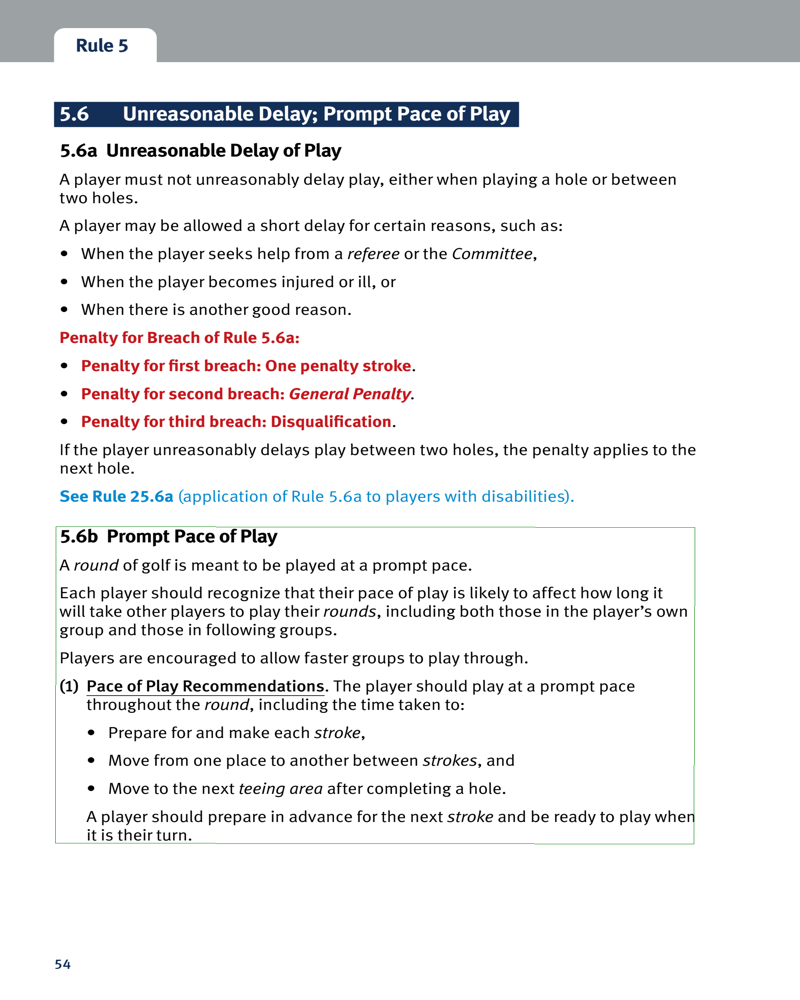

In [91]:
pga_rule_bot("Is there a maximum amount of time that a golf round can take?")